In [1]:
%config InlineBackend.figure_formats=['svg']
import numpy as np
import scipy
import scipy.sparse as sparse
import cvxpy as cp
import matplotlib.pyplot as plt
import remove_first_prop_sdr as api

np.random.seed(0)

In [2]:
N_omega = 15
omega = np.linspace(-2, 2, N_omega)
N_z = 2
z = np.linspace(0, 10**-3, N_z)
delta_z = np.abs(z[1] - z[0])
green_fs = api.get_green_f(omega,z)
projection = np.zeros((N_omega, N_omega))
projections = []
sdr_def_constr = []
B_dagger_B_constr = []
sdr_cst = []
Z_B_dagger_constr = []
for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))
        sdr_def_constr.append(api.sdr_def_constr(N_omega, N_z, sparse.csc_matrix(proj_copy)))
        quad = api.diag_mat(N_omega, N_z, proj_copy)[0] + api.diag_mat(N_omega, N_z, proj_copy)[0].conj().T
        quad.resize(((2*N_z + 1)*N_omega,(2*N_z + 1)*N_omega))
        B_dagger_B_constr.append(quad)
        if i == j:
            sdr_cst.append(2.)
        else:
            sdr_cst.append(0.)

In [61]:
# When the pump is a Gaussian, the Schmidt modes become an anti-diagonal identit...
beta_vec =np.random.random(2*N_omega - 1)#np.array([2.10900246, 2.10794203, 2.10786931, 2.10829837, 2.10790335,
       #2.1076864 , 2.10778626, 2.1078306 , 2.10778798, 2.10783712,
       #2.10781799, 2.1078467 , 2.10784045, 2.10769124, 2.10781962,
       #2.10769124, 2.10784045, 2.1078467 , 2.10781799, 2.10783712,
       #2.10778798, 2.1078306 , 2.10778626, 2.1076864 , 2.10790335,
       #2.10829837, 2.10786931, 2.10794203, 2.10900246])
#np.random.random(2*N_omega - 1)#np.exp(-(np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2)/0.4)#
beta = scipy.linalg.hankel(beta_vec[:N_omega], beta_vec[N_omega - 1:])
new_beta = beta/np.sqrt(np.trace(beta.conj().T@beta))
beta_weight = 30
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta_weight*new_beta
Q_minus = delta_k - beta_weight*new_beta
W_plus = [scipy.linalg.expm(Q_plus*z[i]) for i in range(1, N_z)]
W_minus = [scipy.linalg.expm(Q_minus*z[i]) for i in range(1, N_z)]
J = 0.25*(W_plus[-1]@W_plus[-1].conj().T + W_minus[-1]@W_minus[-1].conj().T - 2*np.eye(N_omega))
n = 0.25*np.trace((W_plus[-1] - W_minus[-1]).conj().T@(W_plus[-1] - W_minus[-1]))
W_plus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_plus*z[i]) for i in range(1, N_z)]
W_minus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_minus*z[i]) for i in range(1, N_z)]
V, D, W = scipy.linalg.svd(W_plus[-1])
rand_unitary = V@W
X = np.vstack([rand_unitary] + W_plus + W_minus + [new_beta])
Y = np.vstack([rand_unitary] + W_plus + W_minus + [new_beta, np.eye(N_omega)])
full_rank = Y@Y.conj().T

In [96]:
# It works!
n = 10**-3
beta_weight = 30
quad = sparse.eye(N_omega)
cst = (N_omega - 1)/np.sqrt(n) + 1 + np.sqrt(1 + 1/n)
quad.resize((N_omega, (N_z + 1)*N_omega))
quad = sparse.bmat([[sparse.csc_matrix((N_omega, (N_z - 1)*N_omega)), quad],
                    [sparse.csc_matrix(((2*N_z - 1)*N_omega, (N_z - 1)*N_omega)), sparse.csc_matrix(((2*N_z - 1)*N_omega, (N_z + 1)*N_omega))]])
quad = 0.5*(quad + quad.conj().T)
mat_plus = sparse.bmat([[quad, sparse.csc_matrix((2*N_z*N_omega, N_omega))],
                   [sparse.csc_matrix((N_omega, 2*N_z*N_omega)), -(cst/N_omega)*sparse.eye(N_omega)]])
quad = sparse.eye(N_omega)
cst = (N_omega - 1)/np.sqrt(n) - 1 + np.sqrt(1 + 1/n)
quad.resize((N_omega, (2)*N_omega))
quad = sparse.bmat([[sparse.csc_matrix((N_omega, (2*N_z - 2)*N_omega)), quad],
                    [sparse.csc_matrix(((2*N_z - 1)*N_omega, (2*N_z - 2)*N_omega)), sparse.csc_matrix(((2*N_z - 1)*N_omega, 2*N_omega))]])
quad = 0.5*(quad + quad.conj().T)
mat_minus = sparse.bmat([[quad, sparse.csc_matrix((2*N_z*N_omega, N_omega))],
                   [sparse.csc_matrix((N_omega, 2*N_z*N_omega)), -(cst/N_omega)*sparse.eye(N_omega)]])
np.trace(Y.conj().T@mat_plus@Y), np.trace(Y.conj().T@mat_minus@Y)

((25.51061433202846+1.734722152487827e-17j),
 (25.716715673379074+6.071528195451885e-17j))

In [97]:
dynamics_constr = []
symplectic_constr = []
unitary_constr = []
fix_pump_constr = []
hermitian_constr = []
pump_limit_constr = api.limit_pump_power(N_omega, N_z)
photon_nbr_constr = api.photon_nbr_constr(N_omega, N_z, n)
hankel_constr = api.constr_hankel_sdr(N_omega, N_z)
left, right, plus_quad, minus_quad = api.obj_f_psd(N_omega, N_z)
both_left, right_plus, right_neg = api.obj_f_psd_parts(N_omega, N_z)
left_B, right_B = api.PSD_B_plus_B_dagger(N_omega, N_z)
for i in range(len(projections)):
    real_plus, imag_plus, real_minus, imag_minus = api.get_dynamics_sdr(omega, z, projections[i], n, beta_weight)
    real_sympl, imag_sympl = api.sympl_constr_sdr(N_omega, N_z, projections[i], n)
    unit_real, unit_imag = api.unitary_constr(N_omega, N_z, projections[i])
    fix_pump_real, fix_pump_imag = api.sdr_fixed_pump(N_omega, N_z, new_beta, projections[i])
    herm_real_plus, herm_imag_plus, herm_real_minus, herm_imag_minus = api.obj_f_mat_hermit(N_omega, N_z, projections[i])
    hermitian_constr += [herm_real_plus, herm_imag_plus, herm_real_minus, herm_imag_minus]
    dynamics_constr += real_plus + imag_plus + real_minus + imag_minus
    symplectic_constr += real_sympl + imag_sympl
    unitary_constr += [unit_real, unit_imag]
    fix_pump_constr += [fix_pump_imag]#, fix_pump_real]
constraints_list = symplectic_constr + dynamics_constr + fix_pump_constr + hankel_constr + unitary_constr + hermitian_constr

In [98]:
[np.trace(Y.conj().T@constraints_list[i]@Y) for i in range(len(constraints_list)) if np.abs(np.trace(Y.conj().T@constraints_list[i]@Y))>10**-3]

[(110.91610689581375+0j),
 (110.91610689581441+0j),
 (110.91610689581404+0j),
 (110.91610689581424+0j),
 (110.91610689581408+0j),
 (110.91610689581407+0j),
 (110.91610689581381+0j),
 (110.91610689581397+0j),
 (110.91610689581412+0j),
 (110.91610689581388+0j),
 (110.91610689581412+0j),
 (110.91610689581398+0j),
 (110.91610689581405+0j),
 (110.9161068958138+0j),
 (110.91610689581398+0j),
 (-1.7095562023511954+4.011825970882184e-23j),
 (0.003419415440430486-1.9958213819679452e-20j),
 (-1.7056999575956877-3.308722450212111e-24j),
 (0.0034116910552571093-2.159934015498466e-20j),
 (-0.002519482034729399+1.2407709188295415e-24j),
 (0.002519573837374326+0j),
 (-0.00195658122960593+1.5923226791645783e-23j),
 (0.0019566669581478767-1.4443348977000132e-24j),
 (-0.002737268482986368-8.271806125530277e-25j),
 (0.0027373583767776226-9.305781891221561e-25j),
 (-0.002378419232157563+6.792910587862032e-21j),
 (0.0023785154496648035-6.777197387397793e-21j),
 (-0.0016856707454863686+0j),
 (0.001685761882

In [65]:
[np.trace(Y.conj().T@sdr_def_constr[i]@Y) - sdr_cst[i] for i in range(len(sdr_cst)) if np.trace(Y.conj().T@sdr_def_constr[i]@Y) - sdr_cst[i] != 0]

[]

In [66]:
np.trace(Y.conj().T@pump_limit_constr@Y)

(4.85722573273506e-17+0j)

In [67]:
np.trace(Y.conj().T@photon_nbr_constr@Y)

(-9.292219771417365e-13+0j)

In [99]:
obj_f = api.obj_f_sdr(N_omega, N_z)

In [120]:
# What if i fix the values of B?
variable = cp.Variable(shape = (5*N_omega, 5*N_omega), hermitian = True)
constraints = [variable >> 0]
constraints += [cp.real(cp.trace(constraints_list[i]@variable)) == 0 for i in range(len(constraints_list))]
# Define the semidefinite relaxation
constraints += [cp.real(cp.trace(sdr_def_constr[i]@variable)) == sdr_cst[i] for i in range(len(sdr_cst))]
# Constraint that makes the B dagger B unitary with Kronecker delta outside of the matrix
#constraints += [cp.real(cp.trace(B_dagger_B_constr[i]@variable)) == sdr_cst[i] for i in range(len(B_dagger_B_constr))]
# Constraint on the pump limit
constraints.append(cp.real(cp.trace(pump_limit_constr@variable)) == 0)
# Constraint on photon number
constraints.append(cp.real(cp.trace(photon_nbr_constr@variable)) == 0)
# Makes the blocks of objective function positive semidefinite
constraints.append(0.5*both_left.conj().T@variable@right_plus >> 0)
constraints.append(0.5*both_left.conj().T@variable@right_neg >> 0)
# Constraint that make matrix of obj f positive semidefinite
# Try to make both propagators hermitian instead...
constraints.append(0.5*left.conj().T@variable@right - 0.25*(W_plus[0] - W_minus[0])@(W_plus[0] - W_minus[0]).conj().T >> 0)
# Constraint to make I - 0.5*(B_Z_dagger + Z_B_dagger) positive semidefintie
constraints.append(sparse.eye(N_omega) - 0.5*(left_B.conj().T@variable@right_B + right_B.conj().T@variable@left_B) >> 0)

# Makes the nuclear norm equal to the case when perfect purity
constraints.append(cp.real(cp.trace(mat_plus@variable)) == 0)
constraints.append(cp.real(cp.trace(mat_minus@variable)) == 0)

# Attempt at minimizing the nuclear norm
isolate_obj_f_left = api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[-1]
isolate_obj_f_left = sparse.vstack([sparse.csc_matrix((N_omega, N_omega)), isolate_obj_f_left])
isolate_obj_f_right = 0.5*(api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[N_z - 1] - api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[2*N_z - 2])
isolate_obj_f_right.resize(((2*N_z + 1)*N_omega, N_omega))
problem = cp.Problem(cp.Minimize(0.), constraints)#cp.atoms.norm(isolate_obj_f_left.conj().T@variable@isolate_obj_f_right, "nuc")

In [121]:
problem.solve(verbose = True, solver = cp.SCS, max_iters = 5*10**5, eps_abs = 1.0e-08, eps_rel = 1.0e-08, eps_infeas = 1.0e-8)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 09 04:57:59 PM: Your problem has 5625 variables, 3355 constraints, and 0 parameters.


(CVXPY) Apr 09 04:57:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 09 04:57:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 09 04:57:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 09 04:57:59 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 09 04:57:59 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 09 04:57:59 PM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 09 04:57:59 PM: Applying reduction Complex2Real
(CVXPY) Apr 09 04:58:00 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 09 04:58:00 

/home/jiaqizhao/miniconda3/envs/cvxpy_opt/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0.0

In [16]:
# Try the objective function of U_plus - U_minus instead of B dagger (U_plus - U_minus)

In [104]:
np.trace(Y.conj().T@obj_f@Y), np.trace(obj_f@end_product)

((0.896949329324708+5.9698965357532226e-18j), (1.0000542575326392+0j))

In [103]:
end_product = variable.value
B_B_dagger = end_product[:N_omega, :N_omega]
B_U_plus_dagger = end_product[:N_omega, N_omega:2*N_omega]
B_U_minus_dagger = end_product[:N_omega, 2*N_omega:3*N_omega]
B_beta_dagger = end_product[:N_omega, 3*N_omega:4*N_omega]
B_Z_dagger = end_product[:N_omega, 4*N_omega:5*N_omega]
U_plus_U_plus_dagger = end_product[N_omega:2*N_omega, N_omega:2*N_omega]
U_plus_U_minus_dagger = end_product[N_omega:2*N_omega, 2*N_omega:3*N_omega]
U_plus_beta_dagger = end_product[N_omega:2*N_omega, 3*N_omega:4*N_omega]
U_plus_Z_dagger = end_product[N_omega:2*N_omega, 4*N_omega:5*N_omega]
U_minus_U_minus_dagger = end_product[2*N_omega:3*N_omega, 2*N_omega:3*N_omega]
U_minus_beta_dagger = end_product[2*N_omega:3*N_omega, 3*N_omega:4*N_omega]
U_minus_Z_dagger = end_product[2*N_omega:3*N_omega, 4*N_omega:5*N_omega]
beta_beta_dagger = end_product[3*N_omega:4*N_omega, 3*N_omega:4*N_omega]
beta_Z_dagger = end_product[3*N_omega:4*N_omega, 4*N_omega:5*N_omega]
Z_Z_dagger = end_product[4*N_omega:5*N_omega, 4*N_omega:5*N_omega]
quadratic_part = end_product[:4*N_omega, :4*N_omega]
lin_part = end_product[:4*N_omega, 4*N_omega:5*N_omega]

In [106]:
[(np.trace(constraints_list[i]@end_product), i) for i in range(len(constraints_list)) if np.abs(np.trace(constraints_list[i]@end_product)) > 10**-4], np.trace(mat_plus@end_product), np.trace(mat_minus@end_product)

([((0.0012189567484028885+0j), 0),
  ((0.001219056248828565+0j), 32),
  ((0.0012191497603453172+0j), 64),
  ((0.001219101179685822+0j), 96),
  ((0.0012191403444603566+0j), 128),
  ((0.0012191215754455698+0j), 160),
  ((0.0012193513002216605+0j), 192),
  ((0.0012192518607889724+0j), 224),
  ((0.001219283791840553+0j), 256),
  ((0.001219327505111778+0j), 288),
  ((0.0012193029987201953+0j), 320),
  ((0.0012192113680384864+0j), 352),
  ((0.0012190196467827263+0j), 384),
  ((0.0012190620734031654+0j), 416),
  ((0.0012189777509092892+0j), 448)],
 (5.280819323161268e-05-1.0339757656912846e-25j),
 (-5.572617214966158e-05+0j))

In [107]:
[np.trace(sdr_def_constr[i]@end_product) - sdr_cst[i] for i in range(len(sdr_def_constr)) if np.abs(np.trace(sdr_def_constr[i]@end_product) - sdr_cst[i]) > 10**-4]

[]

In [108]:
np.max(np.abs(np.imag(B_U_plus_dagger)))

3.0294392772720464e-05

/home/jiaqizhao/miniconda3/envs/cvxpy_opt/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


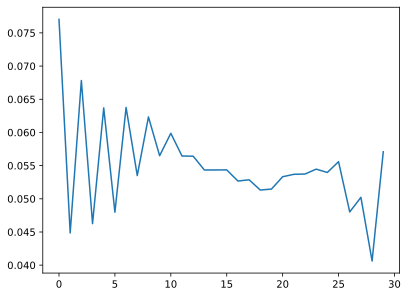

In [109]:
plt.plot(list(beta_Z_dagger[0]) + list(beta_Z_dagger[-1]))

In [110]:
# Frobenius diff when not imposing the positive semidefinite constraint.
np.sqrt(np.trace((np.eye(N_omega) - B_Z_dagger@B_Z_dagger.conj().T).conj().T@(np.eye(N_omega) - B_Z_dagger@B_Z_dagger.conj().T)))/np.sqrt(np.trace(np.eye(N_omega)))

(0.01879084600851619+0j)

In [111]:
np.sqrt(np.trace((np.eye(N_omega) - B_B_dagger).conj().T@(np.eye(N_omega) - B_B_dagger.conj().T)))/np.sqrt(np.trace(np.eye(N_omega)))

(1.0195368109983023e-05+0j)

In [112]:
np.sqrt(np.trace((U_plus_U_plus_dagger - U_plus_Z_dagger@U_plus_Z_dagger.conj().T).conj().T@(U_plus_U_plus_dagger - U_plus_Z_dagger@U_plus_Z_dagger.conj().T)))/np.sqrt(np.trace(U_plus_U_plus_dagger.conj().T@U_plus_U_plus_dagger))

(0.0005261296055403582+0j)

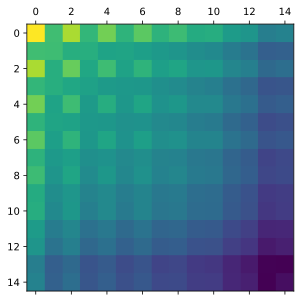

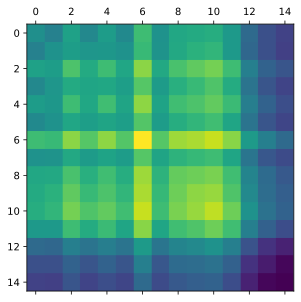

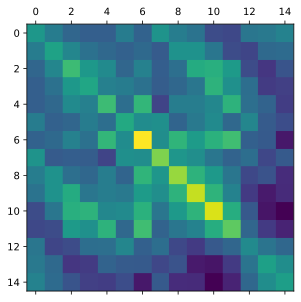

In [113]:
plt.matshow(np.real(beta_Z_dagger@beta_Z_dagger.conj().T))
plt.matshow(np.real(B_beta_dagger.conj().T@B_beta_dagger))
plt.matshow(np.real(beta_beta_dagger))

Text(0, 0.5, 'Frequency index')

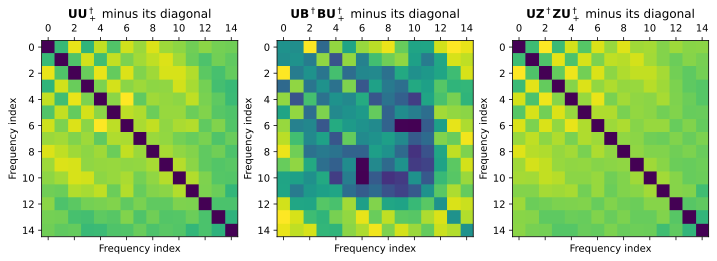

In [114]:
fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, figsize=(12, 8))
ax1.matshow(np.real(U_plus_U_plus_dagger - np.diag(np.diag(U_plus_U_plus_dagger))))
ax1.set_title(r'$\mathbf{U}\mathbf{U}_+^\dagger$ minus its diagonal')
ax1.set_xlabel('Frequency index')
ax1.set_ylabel('Frequency index')
ax2.matshow(np.real(B_U_plus_dagger.conj().T@B_U_plus_dagger - np.diag(np.diag(B_U_plus_dagger.conj().T@B_U_plus_dagger))))
ax2.set_title(r'$\mathbf{U}\mathbf{B}^\dagger\mathbf{B}\mathbf{U}_+^\dagger$ minus its diagonal')
ax2.set_xlabel('Frequency index')
ax2.set_ylabel('Frequency index')
ax3.matshow(np.real(U_plus_Z_dagger@U_plus_Z_dagger.conj().T - np.diag(np.diag(U_plus_Z_dagger@U_plus_Z_dagger.conj().T))))
ax3.set_title(r'$\mathbf{U}\mathbf{Z}^\dagger\mathbf{Z}\mathbf{U}_+^\dagger$ minus its diagonal')
ax3.set_xlabel('Frequency index')
ax3.set_ylabel('Frequency index')

Text(0, 0.5, 'Frequency index')

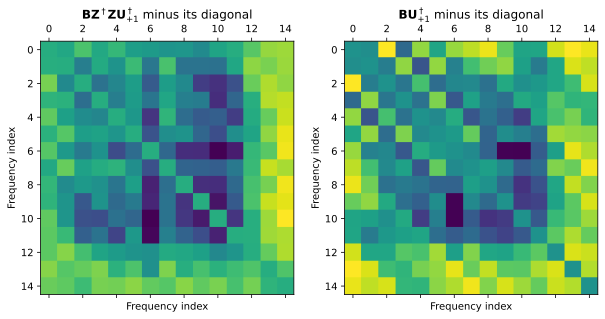

In [119]:
fig, (ax1, ax2)  = plt.subplots(ncols=2, figsize=(10, 5))
ax1.matshow(np.real(B_Z_dagger@U_plus_Z_dagger.conj().T - np.diag(np.diag(B_Z_dagger@U_plus_Z_dagger.conj().T))))
ax1.set_title(r'$\mathbf{B}\mathbf{Z}^\dagger\mathbf{Z}\mathbf{U}_{+1}^\dagger$ minus its diagonal')
ax1.set_xlabel('Frequency index')
ax1.set_ylabel('Frequency index')
ax2.matshow(np.real(B_U_plus_dagger - np.diag(np.diag(B_U_plus_dagger))))
ax2.set_title(r'$\mathbf{B}\mathbf{U}^\dagger_{+1}$ minus its diagonal')
ax2.set_xlabel('Frequency index')
ax2.set_ylabel('Frequency index')

Text(0, 0.5, 'Frequency index')

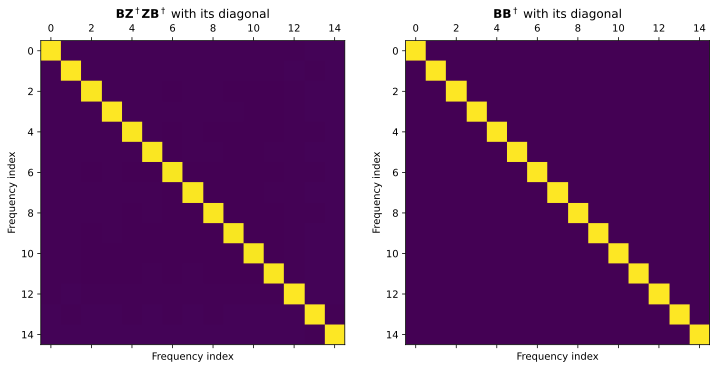

In [116]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12, 8))
ax1.matshow(np.real(B_Z_dagger@B_Z_dagger.conj().T))
ax1.set_title(r'$\mathbf{B}\mathbf{Z}^\dagger\mathbf{Z}\mathbf{B}^\dagger$ with its diagonal')
ax1.set_xlabel('Frequency index')
ax1.set_ylabel('Frequency index')
ax2.matshow(np.real(B_B_dagger))
ax2.set_title(r'$\mathbf{B}\mathbf{B}^\dagger$ with its diagonal')
ax2.set_xlabel('Frequency index')
ax2.set_ylabel('Frequency index')

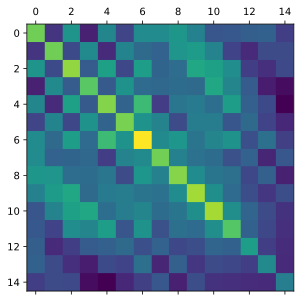

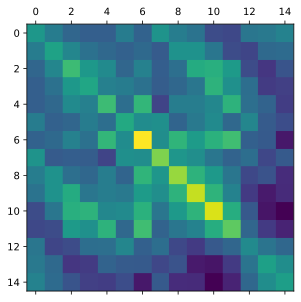

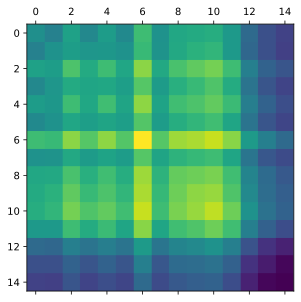

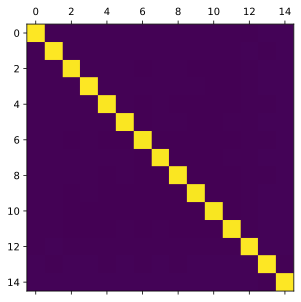

In [117]:
# When not forcing the B (U_plus - U_minus) dagger to be positive semidefinite
plt.matshow(np.real(beta@beta.conj().T))
plt.matshow(np.real(beta_beta_dagger))
plt.matshow(np.real(B_beta_dagger.conj().T@B_beta_dagger))
plt.matshow(np.real(B_Z_dagger@B_Z_dagger.conj().T))

In [25]:
# Frobenius diff when imposing the positive semidefinite constraint
np.sqrt(np.trace((B_Z_dagger@B_Z_dagger.conj().T - np.eye(N_omega)).conj().T@(B_Z_dagger@B_Z_dagger.conj().T - np.eye(N_omega)))), N_omega

((1.022855850582276+0j), 11)

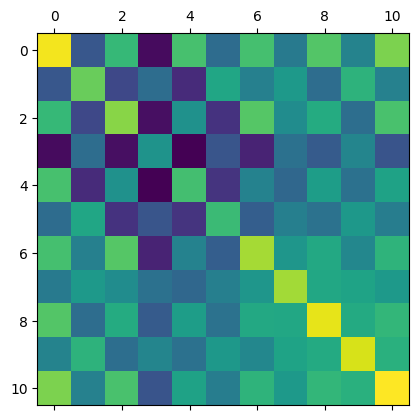

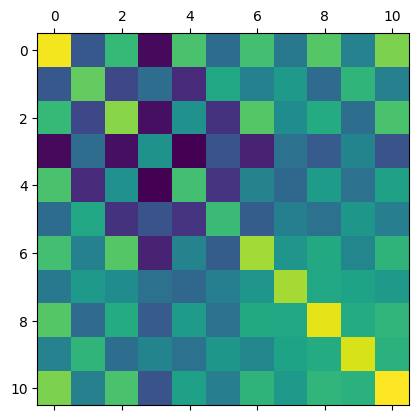

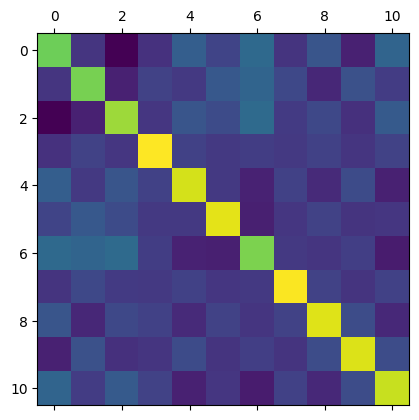

In [26]:
# When forcing the B (U_plus - U_minus) dagger to be positive semidefinite... The B matrix is not unitary
plt.matshow(np.real(beta_beta_dagger))
plt.matshow(np.real(B_beta_dagger.conj().T@B_beta_dagger))
plt.matshow(np.real(B_Z_dagger@B_Z_dagger.conj().T))

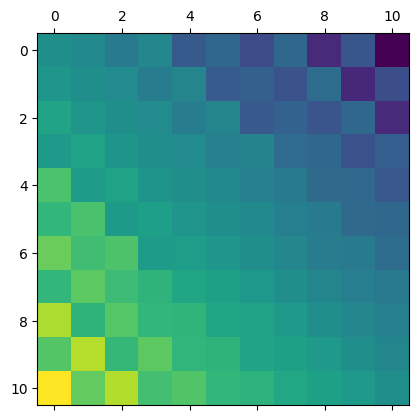

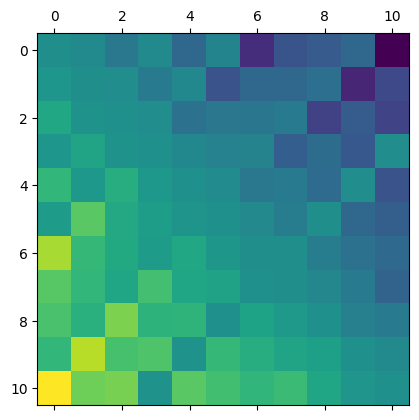

In [27]:
plt.matshow(np.imag(B_U_plus_dagger - B_U_minus_dagger - np.diag(np.diag(B_U_plus_dagger - B_U_minus_dagger))).T)
plt.matshow(np.imag(U_plus_U_plus_dagger + U_plus_U_minus_dagger - (2/n)*np.eye(N_omega)))

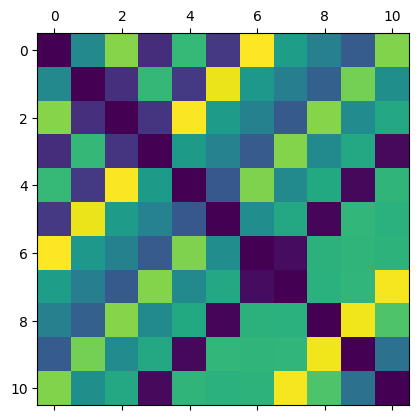

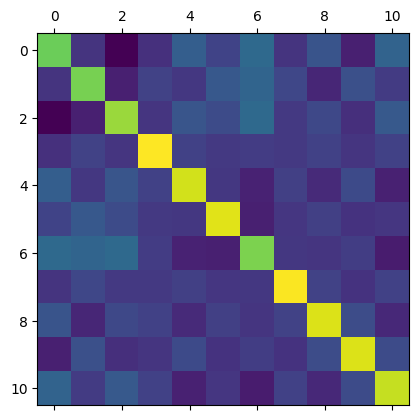

In [28]:
plt.matshow(np.real(U_plus_U_plus_dagger - np.diag(np.diag(U_plus_U_plus_dagger))))
plt.matshow(np.real(B_U_plus_dagger.conj().T@B_U_plus_dagger))

In [29]:
np.linalg.eigvalsh(B_U_plus_dagger - B_U_minus_dagger)

array([-1.80175505, -0.56599325, -0.32129121, -0.3148617 , -0.25602353,
       -0.22175015, -0.2118178 , -0.18969427, -0.13025857, -0.08883471,
       -0.08823701])

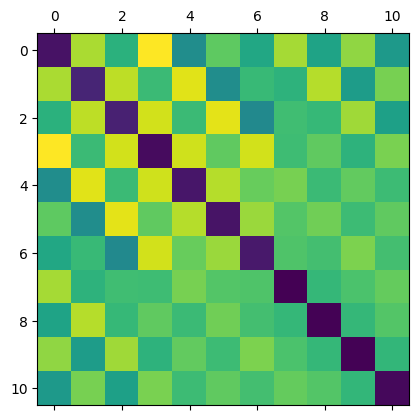

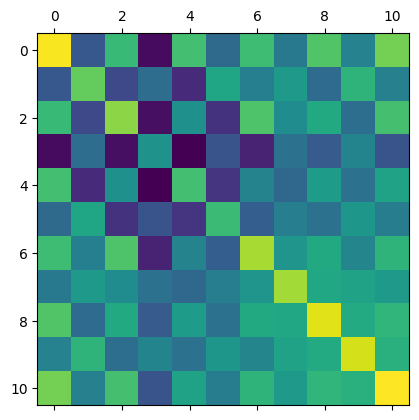

In [30]:
plt.matshow(np.real(B_U_plus_dagger - B_U_minus_dagger))
plt.matshow(np.real(0.25*(U_plus_U_plus_dagger + U_minus_U_minus_dagger - (2/n)*np.eye(N_omega))))

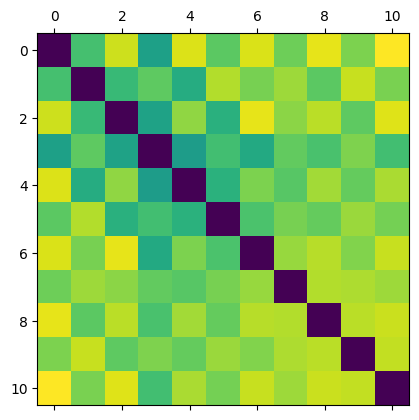

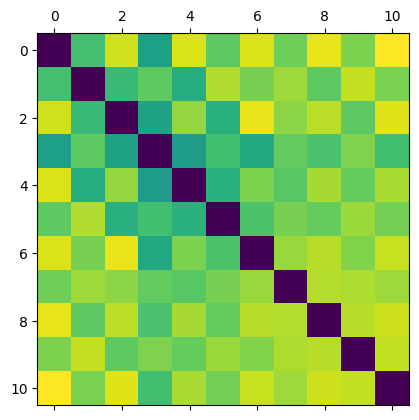

In [33]:
plt.matshow(np.real(beta_Z_dagger@beta_Z_dagger.conj().T - np.diag(np.diag(beta_Z_dagger@beta_Z_dagger.conj().T))))
plt.matshow(np.real(beta_beta_dagger - np.diag(np.diag(beta_beta_dagger))))

In [34]:
# optimal beta and its complex conjugate
np.trace((beta_beta_dagger - beta_Z_dagger@(beta_Z_dagger).conj().T).conj().T@(beta_beta_dagger - beta_Z_dagger@(beta_Z_dagger))), np.trace(beta_beta_dagger)

((6.394260270504993e-07+3.957467482810302e-14j), (1.000000286218537+0j))

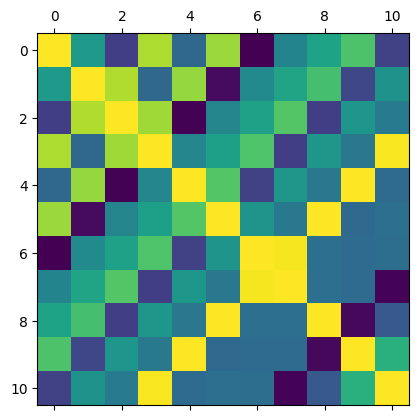

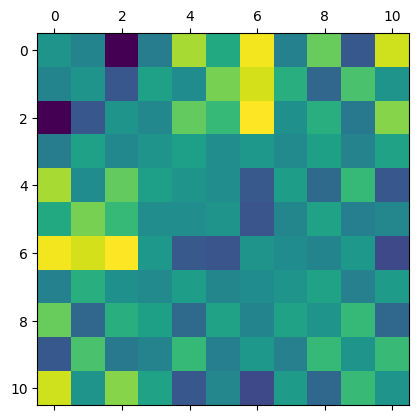

In [35]:
plt.matshow(np.real(U_minus_U_minus_dagger - np.diag(np.diag(U_minus_U_minus_dagger))))
plt.matshow(np.real(B_U_minus_dagger.conj().T@B_U_minus_dagger - np.diag(np.diag(B_U_minus_dagger.conj().T@B_U_minus_dagger))))

In [36]:
[np.trace(constraints_list[i]@end_product) for i in range(len(constraints_list)) if np.abs(np.trace(constraints_list[i]@end_product)) > 10**-4]

[]

In [37]:
[np.trace(sdr_def_constr[i]@end_product) - sdr_cst[i] for i in range(len(sdr_def_constr)) if np.abs(np.trace(sdr_def_constr[i]@end_product) - sdr_cst[i]) > 10**-4]

[]

In [38]:
np.linalg.eigvalsh(left.conj().T@end_product@right)

array([-1.80175505, -0.56599325, -0.32129121, -0.3148617 , -0.25602353,
       -0.22175015, -0.2118178 , -0.18969427, -0.13025857, -0.08883471,
       -0.08823701])